# Import Modules and Data

In [5]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
import random
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv(r'data_files\data_share\train.csv')
test = pd.read_csv(r'data_files\data_share\test.csv')
val = pd.read_csv(r'data_files\data_share\val.csv')

# Seeding

In [6]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

# Split on the basis of wheat's sowing period

In [12]:
# combining all the data

df = pd.concat([wheat.drop(['mar_2f', 'apr_1f'], axis=1), non_wheat], ignore_index=True)

# Converting the mustard and pulses data to a common label which is non-wheat

df['label'] = df.label.apply(lambda crop: 'Non_Wheat' if crop[:5] != 'Wheat' else crop)

# Will not be considering dec_2f and oct_2f for now due to very less number of datapoints.

display(df.label.value_counts())

Wheat_nov_2f    7172
Wheat_dec_1f    5552
Wheat_nov_1f    3636
Non_Wheat       2500
Wheat_dec_2f     245
Wheat_oct_2f      94
Name: label, dtype: int64

In [13]:
# Creating different datasets for training a wheat vs non wheat classifier
# Label encoding wheat as 1 and non wheat as 0

tr_nov1f_nw = df[(df.label == 'Wheat_nov_1f') | (df.label == 'Non_Wheat')]
tr_nov1f_nw['label'] = tr_nov1f_nw.label.apply(lambda crop: 0 if crop[:5] != 'Wheat' else 1)

tr_nov2f_nw = df[(df.label == 'Wheat_nov_2f') | (df.label == 'Non_Wheat')]
tr_nov2f_nw['label'] = tr_nov2f_nw.label.apply(lambda crop: 0 if crop[:5] != 'Wheat' else 1)

tr_dec1f_nw = df[(df.label == 'Wheat_dec_1f') | (df.label == 'Non_Wheat')]
tr_dec1f_nw['label'] = tr_dec1f_nw.label.apply(lambda crop: 0 if crop[:5] != 'Wheat' else 1)

# Data Preparation - Test and Validation

In [14]:
# Initial Preprocessing.

threshold = 5

def sowing_period(row):
    sowing_periods = row.index[:5]
    sowing_periods_NDVI = row[:5]
    minima = np.argmin(sowing_periods_NDVI)
    ndvi_values = row.loc[:'mar_1f']
    i = minima
    while i < len(sowing_periods):
#         print(ndvi_values[idx])
        if ndvi_values[i] in set(np.arange(110, 141)):
            if (ndvi_values[i+1] - ndvi_values[i]) > threshold:
                if ndvi_values[i+1] < ndvi_values[i+4]:
                    return 'Wheat_'+sowing_periods[i]
        i += 1
    return 'Unknown'
            
def new_GT_initial_preprocess():
    
    files = np.array(glob(r'data_files\new+old\new\**\*.xlsx', recursive=True))

    series = pd.Series(pd.read_excel(files[0]).columns)
    ndvi_cols = list(series[series.apply(lambda row : True if 'FN' in row else False)])
    
    columns = ['oct_2f', 'nov_1f', 'nov_2f', 'dec_1f', 'dec_2f', 'jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f', 'label']
    
    wheat = pd.DataFrame(columns = columns)
    mustard = pd.DataFrame(columns = columns)

    for file in files:
        temp = pd.read_excel(file)[ndvi_cols[1:11]]
        temp.columns = columns[:-1]
        # temp['district'] = 'SHIVPURI' * temp.shape[0]
        if 'Wheat' in file:
            temp['label'] = ['Wheat']*temp.shape[0]
            wheat = pd.concat([wheat, temp],ignore_index=True)
        else:
            temp['label'] = ['Non_Wheat']*temp.shape[0]
            mustard = pd.concat([mustard, temp], ignore_index=True)
            
    wheat.iloc[:,:-1] = wheat.iloc[:,:-1].apply(lambda row:round(row*100+100))
    mustard.iloc[:,:-1] = mustard.iloc[:,:-1].apply(lambda row:round(row*100+100))
    
    wheat['label'] = wheat.iloc[:,:-1].apply(sowing_period, axis=1)

#     wheat['label'] = wheat.label.apply(fn_encoding)

    df = pd.concat([wheat, mustard], ignore_index=True)
    
#     df.dropna(inplace=True)
    
    return df


val_test = new_GT_initial_preprocess()

# A vast majority are labelled as unknowns
val_test.label.value_counts()

Wheat_dec_1f    2363
Wheat_nov_2f    2255
Unknown         1102
Wheat_nov_1f     900
Wheat_dec_2f     845
Non_Wheat        809
Wheat_oct_2f      49
Name: label, dtype: int64

Minima over 140: 946


,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f
1571,158.0,148.0,136.0,141.0,165.0,180.0,177.0,180.0,170.0,161.0
6242,159.0,155.0,156.0,148.0,185.0,193.0,196.0,194.0,196.0,181.0
1318,166.0,154.0,140.0,143.0,160.0,167.0,173.0,179.0,177.0,173.0
5430,154.0,155.0,159.0,162.0,162.0,142.0,200.0,191.0,192.0,190.0
1511,181.0,169.0,176.0,172.0,186.0,180.0,174.0,181.0,176.0,174.0
6476,158.0,159.0,155.0,154.0,167.0,172.0,174.0,175.0,177.0,166.0
2972,167.0,161.0,153.0,141.0,164.0,177.0,175.0,185.0,183.0,182.0
6314,152.0,148.0,147.0,149.0,145.0,154.0,169.0,183.0,186.0,173.0
3744,169.0,161.0,159.0,149.0,161.0,182.0,182.0,189.0,185.0,183.0
1331,170.0,157.0,139.0,141.0,154.0,169.0,173.0,180.0,179.0,173.0


<Axes: >

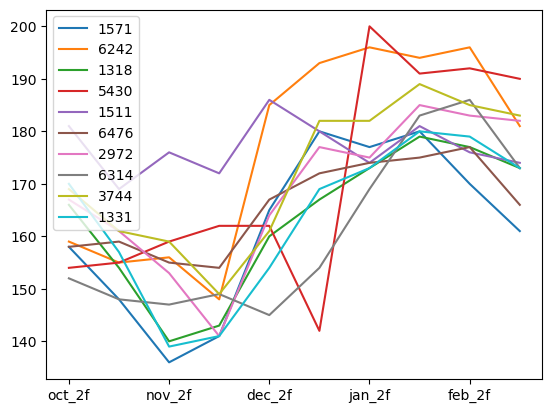

In [15]:
# There are 946 rows with minima over 140
print('Minima over 140:',(val_test[val_test.label == 'Unknown'].min(axis=1) >= 140).sum())

# Sample Unknown plot
display(val_test[val_test.label == 'Unknown'].loc[:,:'mar_1f'].sample(10, random_state=1))
val_test[val_test.label == 'Unknown'].loc[:,:'mar_1f'].sample(10, random_state=1).T.plot()

## Final split on the basis of wheat's sowing period

In [16]:
# Creating different datasets for validation and testing of a wheat vs non wheat classifier
# Label encoding wheat as 1 and non wheat as 0

val_tst_nov1f_nw = val_test[(val_test.label == 'Wheat_nov_1f') | (val_test.label == 'Non_Wheat')]
val_tst_nov1f_nw['label'] = val_tst_nov1f_nw.label.apply(lambda crop: 0 if crop[:5] != 'Wheat' else 1)

val_tst_nov2f_nw = val_test[(val_test.label == 'Wheat_nov_2f') | (val_test.label == 'Non_Wheat')]
val_tst_nov2f_nw['label'] = val_tst_nov2f_nw.label.apply(lambda crop: 0 if crop[:5] != 'Wheat' else 1)

val_tst_dec1f_nw = val_test[(val_test.label == 'Wheat_dec_1f') | (val_test.label == 'Non_Wheat')]
val_tst_dec1f_nw['label'] = val_tst_dec1f_nw.label.apply(lambda crop: 0 if crop[:5] != 'Wheat' else 1)

# Wheat Nov_1F vs Non Wheat

## Undersampling - Atleast 70:30(wheat/Non_wheat)

In [16]:
# Undersampling not required as we have a 60 to 40 ratio.

tr_nov1f_nw.label.value_counts(normalize=True)

1    0.592568
0    0.407432
Name: label, dtype: float64

## Predictor and label split

In [17]:
pred_cols = tr_nov1f_nw.loc[:,'nov_1f':'mar_1f'].columns

X_train = tr_nov1f_nw[pred_cols]
y_train = tr_nov1f_nw['label']

X_val_test = val_tst_nov1f_nw[pred_cols]
y_val_test = val_tst_nov1f_nw['label']

y_val_test = y_val_test.astype('int')

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, 
                                                  stratify=y_val_test, random_state=0)

# X_train.drop('fn_label', axis=1, inplace=True)
# # X_val.drop('fn_label', axis=1, inplace=True)

## Scaling

In [18]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

pickle.dump(scaler, open(r'models/XGB_Binary_sowing-nov1f_StandardScaler_1.1', 'wb'))

## Modelling-Manual

- Labels =  1 : 'Wheat_nov_1f, 0 : Non-Wheat
- FP = GT is non wheat but model predicted wheat
- FN = GT is wheat but model predicted non wheat

- Will be training my model on the recall score of non wheat class

In [19]:
fort_nights = list(X_train.loc[:, :'mar_1f'].columns)

params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

# sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = list(ParameterGrid(params))
max_recall_scores = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    recall_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1])
        recall_scores.append(recall)
        
    recall_scores = pd.DataFrame(recall_scores)
    # Max Non_wheat recall where Wheat recall is atleast 0.79
    try:
        max_nw_idx = recall_scores[recall_scores.iloc[:,1]>0.79].idxmax(axis=0)[0]
        max_nw_scores = recall_scores.loc[max_nw_idx,:].values
        max_recall_scores.append([max_nw_scores, param_grid[max_nw_idx]])

        fns_used.append('-'.join(temp_X_train.columns[[0,-1]]))
        print(len(drop_cols), 'dropped', 'completed')
    except:
        print(f'Wheat Recall is less than 0.79 if {drop_cols} are dropped')
    
    i += 1
    
print('Done!!')

0 dropped completed
1 dropped completed
2 dropped completed
3 dropped completed
4 dropped completed
Wheat Recall is less than 0.79 if ['jan_1f', 'jan_2f', 'feb_1f', 'feb_2f', 'mar_1f'] are dropped
Done!!


In [20]:
max_recall_scores

[[array([0.99752475, 0.87777778]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 30}],
 [array([0.99752475, 0.87777778]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 30}],
 [array([1.        , 0.81777778]),
  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 15}],
 [array([1.        , 0.81777778]),
  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 15}],
 [array([1.        , 0.81777778]),
  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 15}]]

In [23]:
test_recall_scores = []
confusion_matrices = []
test_dfs = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**max_recall_scores[i][1])
    
    strt_fn, end_fn = fns_used[i].split('-') 
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train)
    pickle.dump(best_classifier, open(r'models/XGB_Binary_sowing-nov1f_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    precision, recall, f1score, support = score(y_test, test_pred, labels=[0,1])
    test_recall_scores.append([recall[0], round(recall[1], 2)])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Non_wheat', 1:'Wheat'}).rename({0:'Non_wheat', 1:'Wheat'}, axis=1)
    confusion_matrices.append(cf)
    df1 = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df1['correct_pred(%)'] = round(df1['correct_pred']/df1['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df1 = pd.concat([df1, temp_df], axis=1)
    test_dfs.append(df1)
    print(test_recall_scores[-1])

[0.9975308641975309, 0.86]
[0.9975308641975309, 0.86]
[1.0, 0.81]
[1.0, 0.81]
[1.0, 0.81]


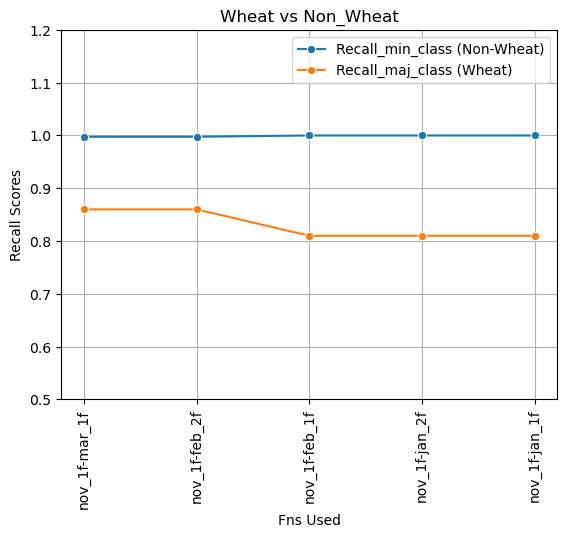

In [34]:
sns.lineplot(y=np.array(test_recall_scores)[:,0], x=fns_used, label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,1], x=fns_used, label='Recall_maj_class (Wheat)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

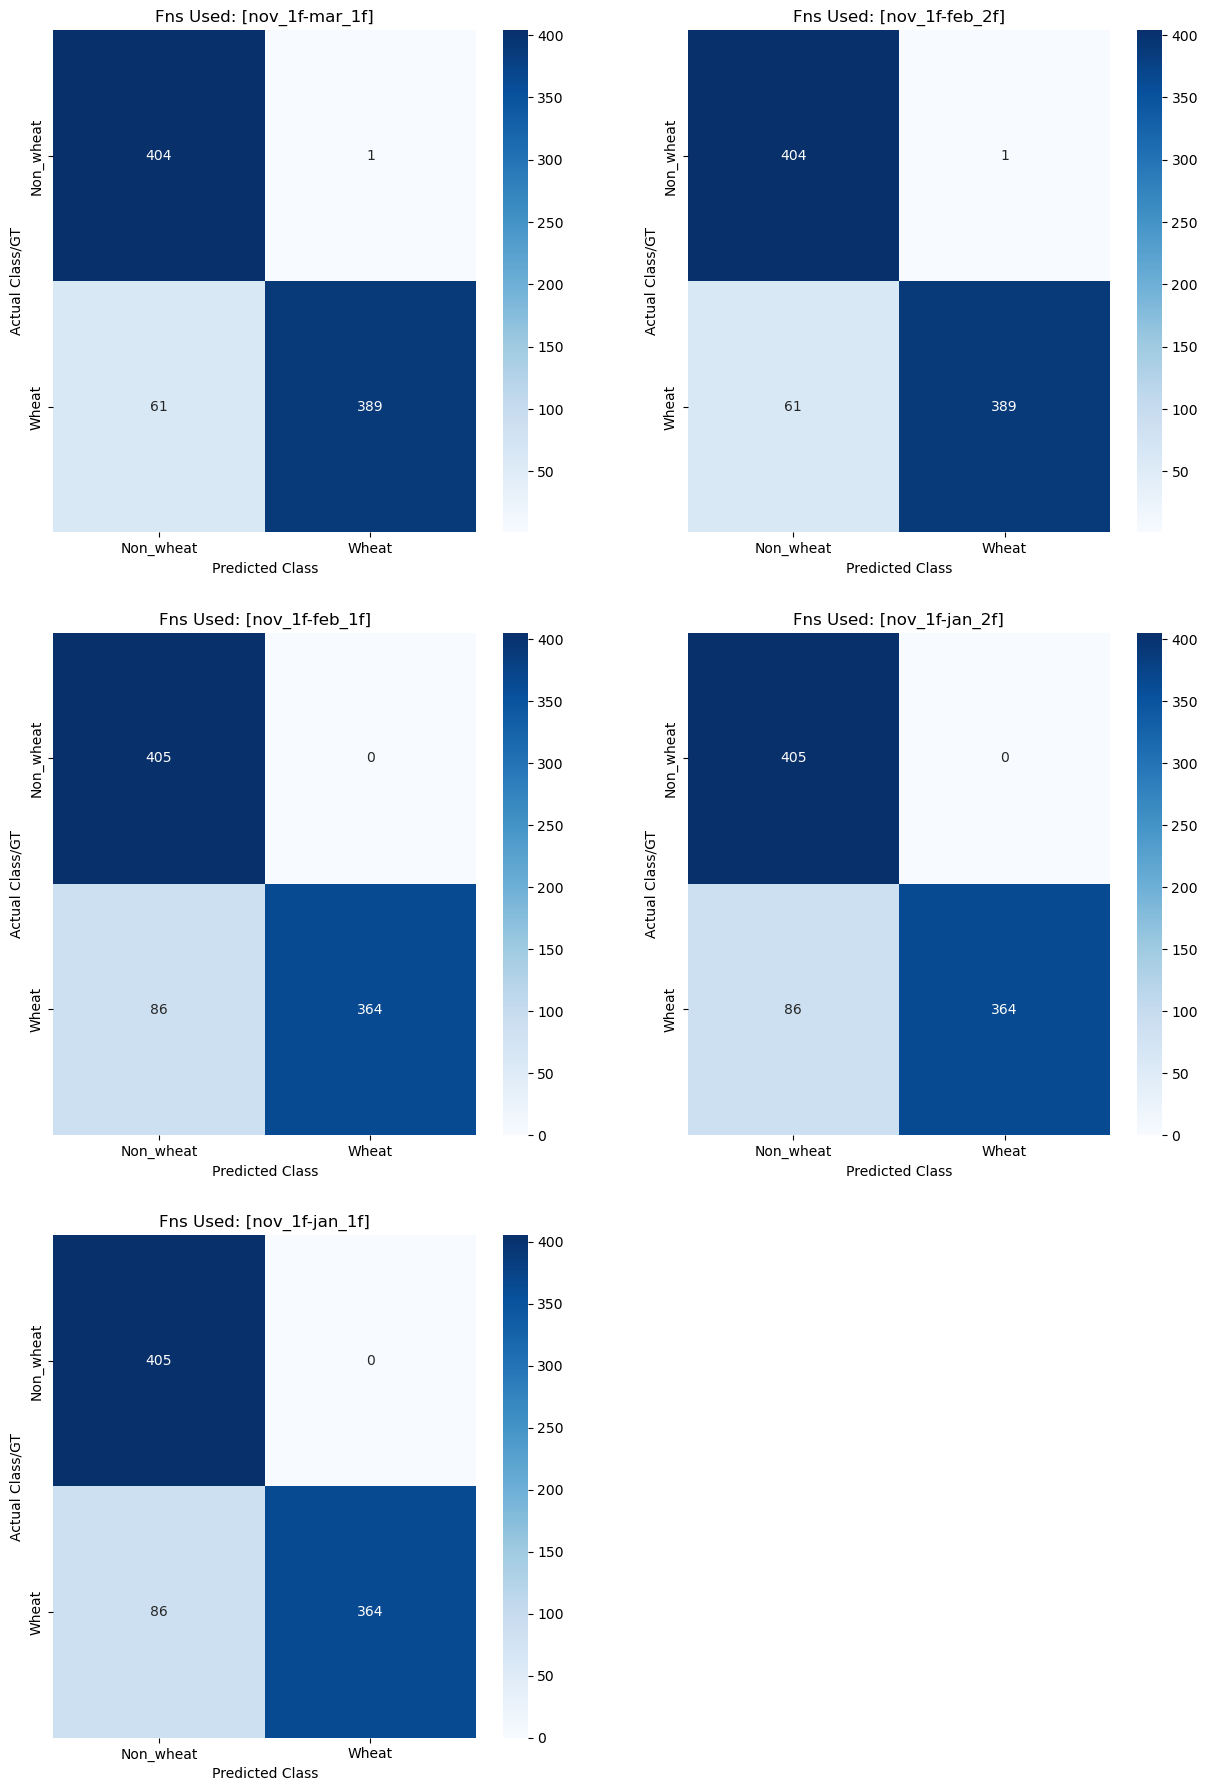

In [35]:
plt.figure(figsize=(15,30))

for i in range(len(confusion_matrices)):
    plt.subplot(4,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()

# Wheat Nov_2F vs Non Wheat

## Undersampling - Atleast 70:30(wheat/Non_wheat)

In [18]:
# Undersampling not required as the ratio is close to 70:30

(tr_nov2f_nw.label.value_counts(normalize=True))

1    0.741522
0    0.258478
Name: label, dtype: float64

## Predictor and label split

In [19]:
pred_cols = tr_nov2f_nw.loc[:,'nov_2f':'mar_1f'].columns

X_train = tr_nov2f_nw[pred_cols]
y_train = tr_nov2f_nw['label']

X_val_test = val_tst_nov2f_nw[pred_cols]
y_val_test = val_tst_nov2f_nw['label']

y_val_test = y_val_test.astype('int')

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, 
                                                  stratify=y_val_test, random_state=0)

# X_train.drop('fn_label', axis=1, inplace=True)
# # X_val.drop('fn_label', axis=1, inplace=True)

## Scaling

In [20]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

pickle.dump(scaler, open(r'models/XGB_Binary_sowing-nov2f_StandardScaler_1.1', 'wb'))

## Modelling-Manual

- Labels =  1 : 'Wheat_nov_2f, 0 : Non-Wheat
- FP = GT is non wheat but model predicted wheat
- FN = GT is wheat but model predicted non wheat

- Will be training my model on the recall score of non wheat class

In [21]:
fort_nights = list(X_train.loc[:, :'mar_1f'].columns)

params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

# sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = list(ParameterGrid(params))
max_recall_scores = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    recall_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1])
        recall_scores.append(recall)
        
    recall_scores = pd.DataFrame(recall_scores)
    # Max Non_wheat recall where Wheat recall is atleast 0.79
    try:
        max_nw_idx = recall_scores[recall_scores.iloc[:,1]>0.79].idxmax(axis=0)[0]
        max_nw_scores = recall_scores.loc[max_nw_idx,:].values
        max_recall_scores.append([max_nw_scores, param_grid[max_nw_idx]])

        fns_used.append('-'.join(temp_X_train.columns[[0,-1]]))
        print(len(drop_cols), 'dropped', 'completed')
    except:
        print(f'Wheat Recall is less than 0.79 if {drop_cols} are dropped')
    
    i += 1
    
print('Done!!')

0 dropped completed
1 dropped completed
2 dropped completed
3 dropped completed
4 dropped completed
Done!!


In [23]:
max_recall_scores

[[array([1.        , 0.85549645]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 70}],
 [array([1.        , 0.85549645]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 70}],
 [array([1.        , 0.85638298]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 75}],
 [array([0.99752475, 0.85904255]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 5}],
 [array([0.99752475, 0.85904255]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 5}]]

In [24]:
test_recall_scores = []
confusion_matrices = []
test_dfs = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**max_recall_scores[i][1])
    
    strt_fn, end_fn = fns_used[i].split('-') 
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train)
    pickle.dump(best_classifier, open(r'models/XGB_Binary_sowing-nov2f_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    precision, recall, f1score, support = score(y_test, test_pred, labels=[0,1])
    test_recall_scores.append([recall[0], round(recall[1], 2)])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Non_wheat', 1:'Wheat'}).rename({0:'Non_wheat', 1:'Wheat'}, axis=1)
    confusion_matrices.append(cf)
    df1 = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df1['correct_pred(%)'] = round(df1['correct_pred']/df1['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df1 = pd.concat([df1, temp_df], axis=1)
    test_dfs.append(df1)
    print(test_recall_scores[-1])

[1.0, 0.87]
[1.0, 0.87]
[1.0, 0.87]
[1.0, 0.88]
[1.0, 0.88]


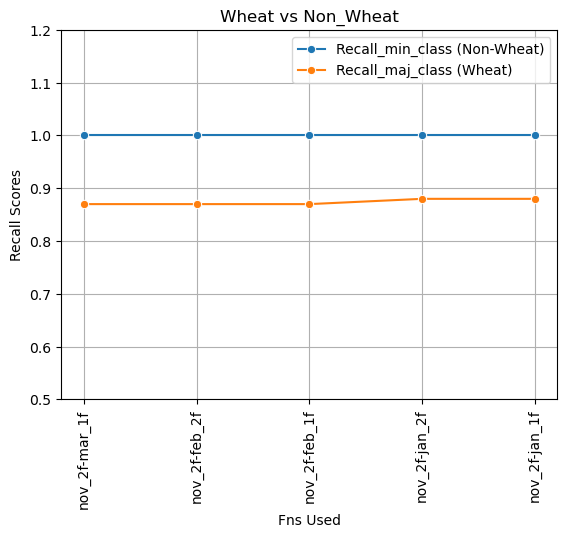

In [26]:
sns.lineplot(y=np.array(test_recall_scores)[:,0], x=fns_used, label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,1], x=fns_used, label='Recall_maj_class (Wheat)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

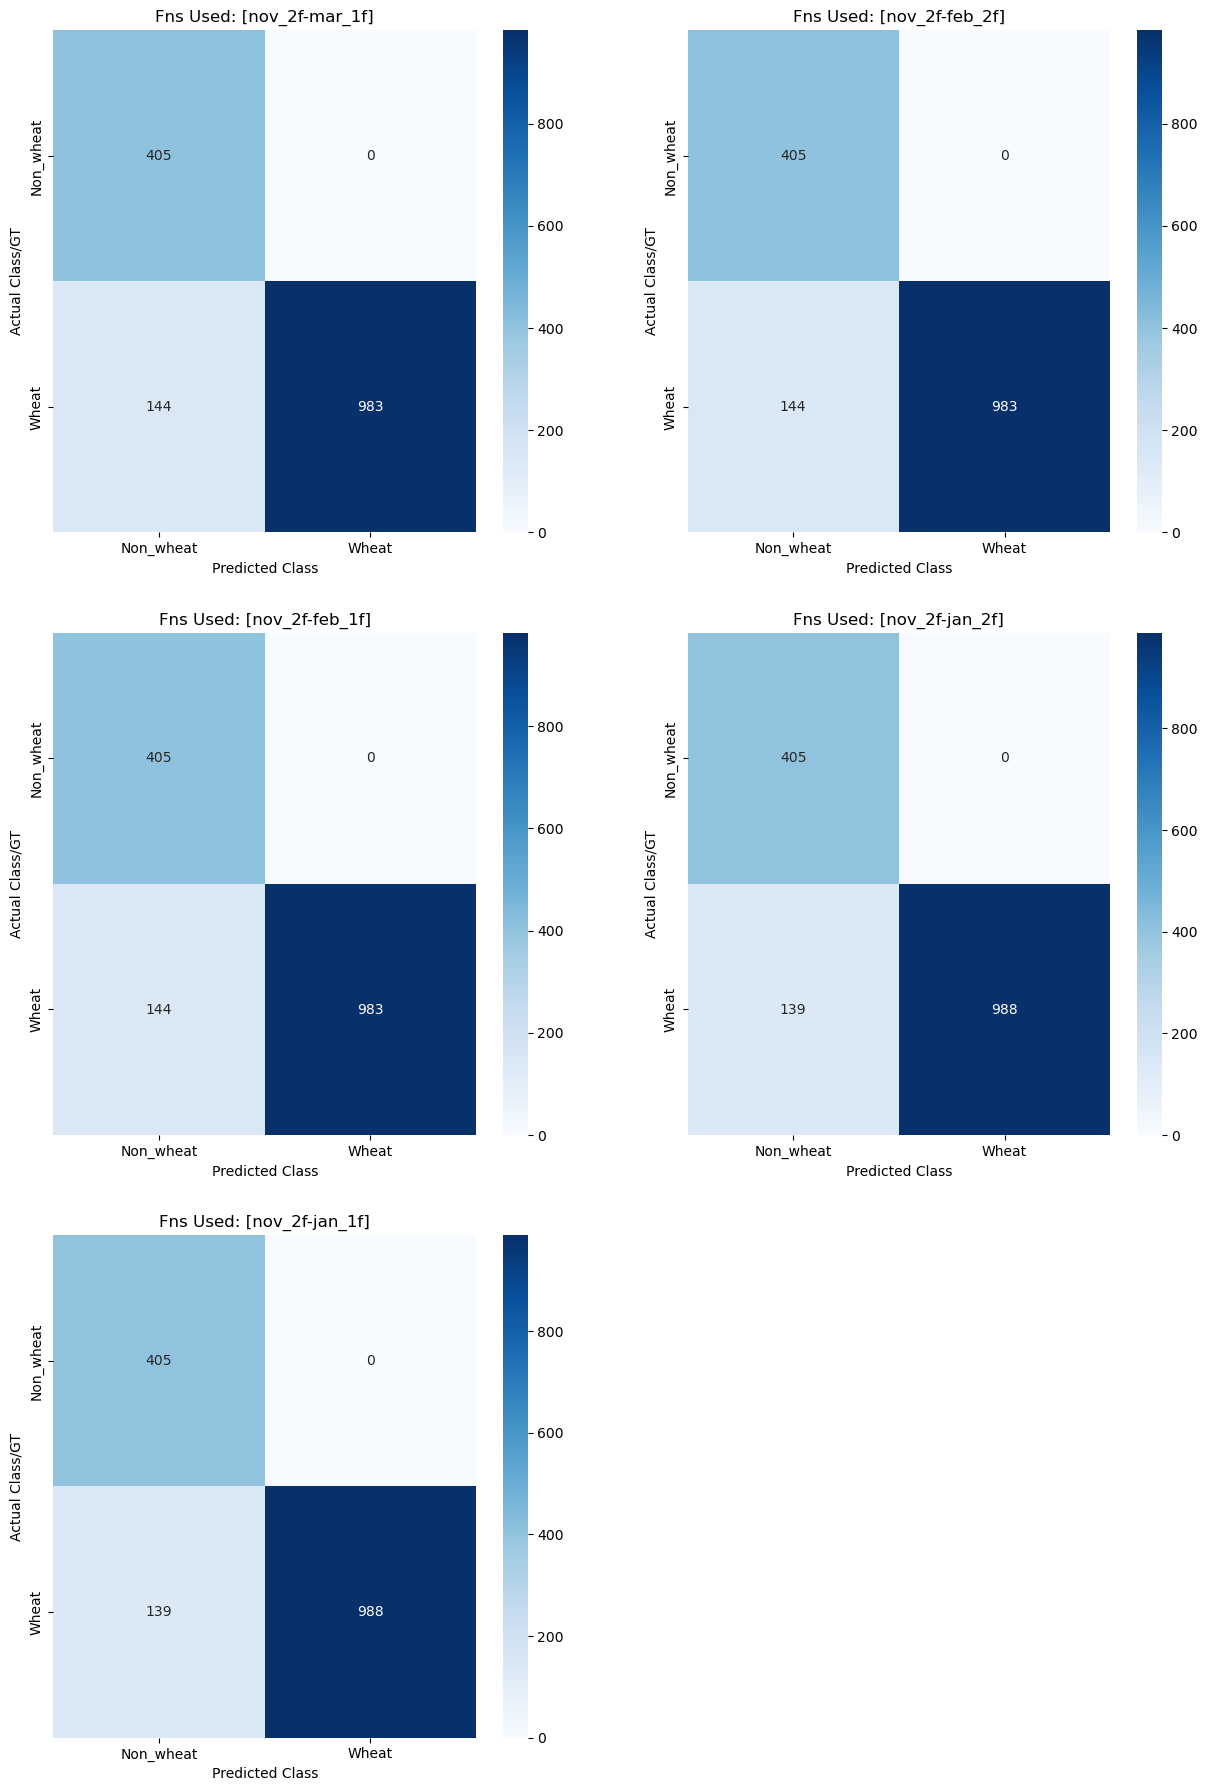

In [27]:
plt.figure(figsize=(15,30))

for i in range(len(confusion_matrices)):
    plt.subplot(4,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()

# Wheat Dec_1F vs Non Wheat

## Undersampling - Atleast 70:30(wheat/Non_wheat)

In [32]:
# Undersampling is not required.

tr_dec1f_nw.label.value_counts(normalize=True)

1    0.689518
0    0.310482
Name: label, dtype: float64

## Predictor and label split

In [33]:
pred_cols = tr_dec1f_nw.loc[:,'dec_1f':'mar_1f'].columns

X_train = tr_dec1f_nw[pred_cols]
y_train = tr_dec1f_nw['label']

X_val_test = val_tst_dec1f_nw[pred_cols]
y_val_test = val_tst_dec1f_nw['label']

y_val_test = y_val_test.astype('int')

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, shuffle=True, 
                                                  stratify=y_val_test, random_state=0)

# X_train.drop('fn_label', axis=1, inplace=True)
# # X_val.drop('fn_label', axis=1, inplace=True)

## Scaling

In [34]:
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

pickle.dump(scaler, open(r'models/XGB_Binary_sowing-dec1f_StandardScaler_1.1', 'wb'))

## Modelling-Manual

- Labels =  1 : 'Wheat_nov_2f, 0 : Non-Wheat
- FP = GT is non wheat but model predicted wheat
- FN = GT is wheat but model predicted non wheat

- Will be training my model on the recall score of non wheat class

In [35]:
fort_nights = list(X_train.loc[:, :'mar_1f'].columns)

params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

# sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = list(ParameterGrid(params))
max_recall_scores = []
fns_used = []

i = 0

while (i + 4) <= len(fort_nights):
    recall_scores = []
    if i == 0:
        drop_cols = []
    else:
        drop_cols = fort_nights[-i:]
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        temp_X_train = X_train.drop(drop_cols, axis=1)
        temp_X_val = X_val.drop(drop_cols, axis=1)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1])
        recall_scores.append(recall)
        
    recall_scores = pd.DataFrame(recall_scores)
    # Max Non_wheat recall where Wheat recall is atleast 0.79
    try:
        max_nw_idx = recall_scores[recall_scores.iloc[:,1]>0.79].idxmax(axis=0)[0]
        max_nw_scores = recall_scores.loc[max_nw_idx,:].values
        max_recall_scores.append([max_nw_scores, param_grid[max_nw_idx]])

        fns_used.append('-'.join(temp_X_train.columns[[0,-1]]))
        print(len(drop_cols), 'dropped', 'completed')
    except:
        print(f'Wheat Recall is less than 0.79 if {drop_cols} are dropped')
    
    i += 1
    
print('Done!!')

0 dropped completed
1 dropped completed
2 dropped completed
3 dropped completed
Done!!


In [36]:
max_recall_scores

[[array([1.        , 0.92978003]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 5}],
 [array([1.        , 0.92978003]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 5}],
 [array([1.        , 0.82910321]),
  {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 70}],
 [array([0.99752475, 1.        ]),
  {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 5}]]

In [37]:
test_recall_scores = []
confusion_matrices = []
test_dfs = []

for i in range(len(fns_used)):
    best_classifier = XGBClassifier(**max_recall_scores[i][1])
    
    strt_fn, end_fn = fns_used[i].split('-') 
    temp_X_train = X_train.loc[:, strt_fn:end_fn]
    temp_X_test = X_test.loc[:, strt_fn:end_fn]
    best_classifier.fit(temp_X_train, y_train)
    pickle.dump(best_classifier, open(r'models/XGB_Binary_sowing-dec1f_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    precision, recall, f1score, support = score(y_test, test_pred, labels=[0,1])
    test_recall_scores.append([recall[0], round(recall[1], 2)])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Non_wheat', 1:'Wheat'}).rename({0:'Non_wheat', 1:'Wheat'}, axis=1)
    confusion_matrices.append(cf)
    df1 = pd.DataFrame(data = {'GT':confusion_matrices[-1].sum(axis=1),
                                    'correct_pred':np.diag(confusion_matrices[-1])})
    df1['correct_pred(%)'] = round(df1['correct_pred']/df1['GT']*100, 2)
    temp_df = deepcopy(confusion_matrices[-1])
    np.fill_diagonal(temp_df.values, 0)
    temp_df.columns = ['incorr_pred_nw', 'incorrect_pred_wh']
    df1 = pd.concat([df1, temp_df], axis=1)
    test_dfs.append(df1)
    print(test_recall_scores[-1])

[1.0, 0.94]
[1.0, 0.94]
[1.0, 0.84]
[1.0, 1.0]


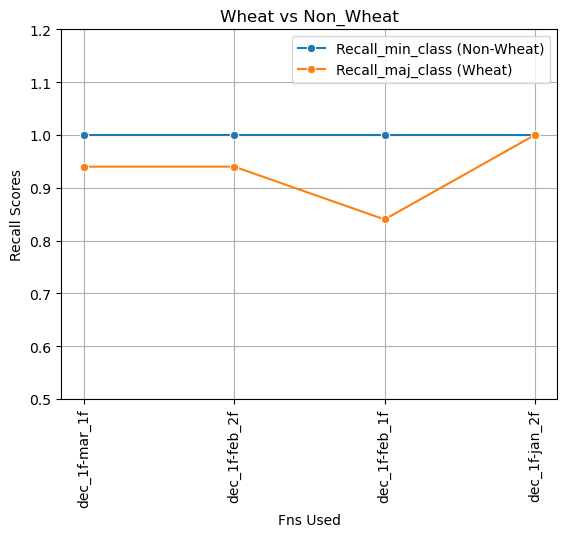

In [38]:
sns.lineplot(y=np.array(test_recall_scores)[:,0], x=fns_used, label='Recall_min_class (Non-Wheat)', marker="o")
sns.lineplot(y=np.array(test_recall_scores)[:,1], x=fns_used, label='Recall_maj_class (Wheat)', marker="o")
plt.xlabel('Fns Used')
plt.ylabel('Recall Scores')
plt.xticks(rotation='vertical')
plt.title('Wheat vs Non_Wheat')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

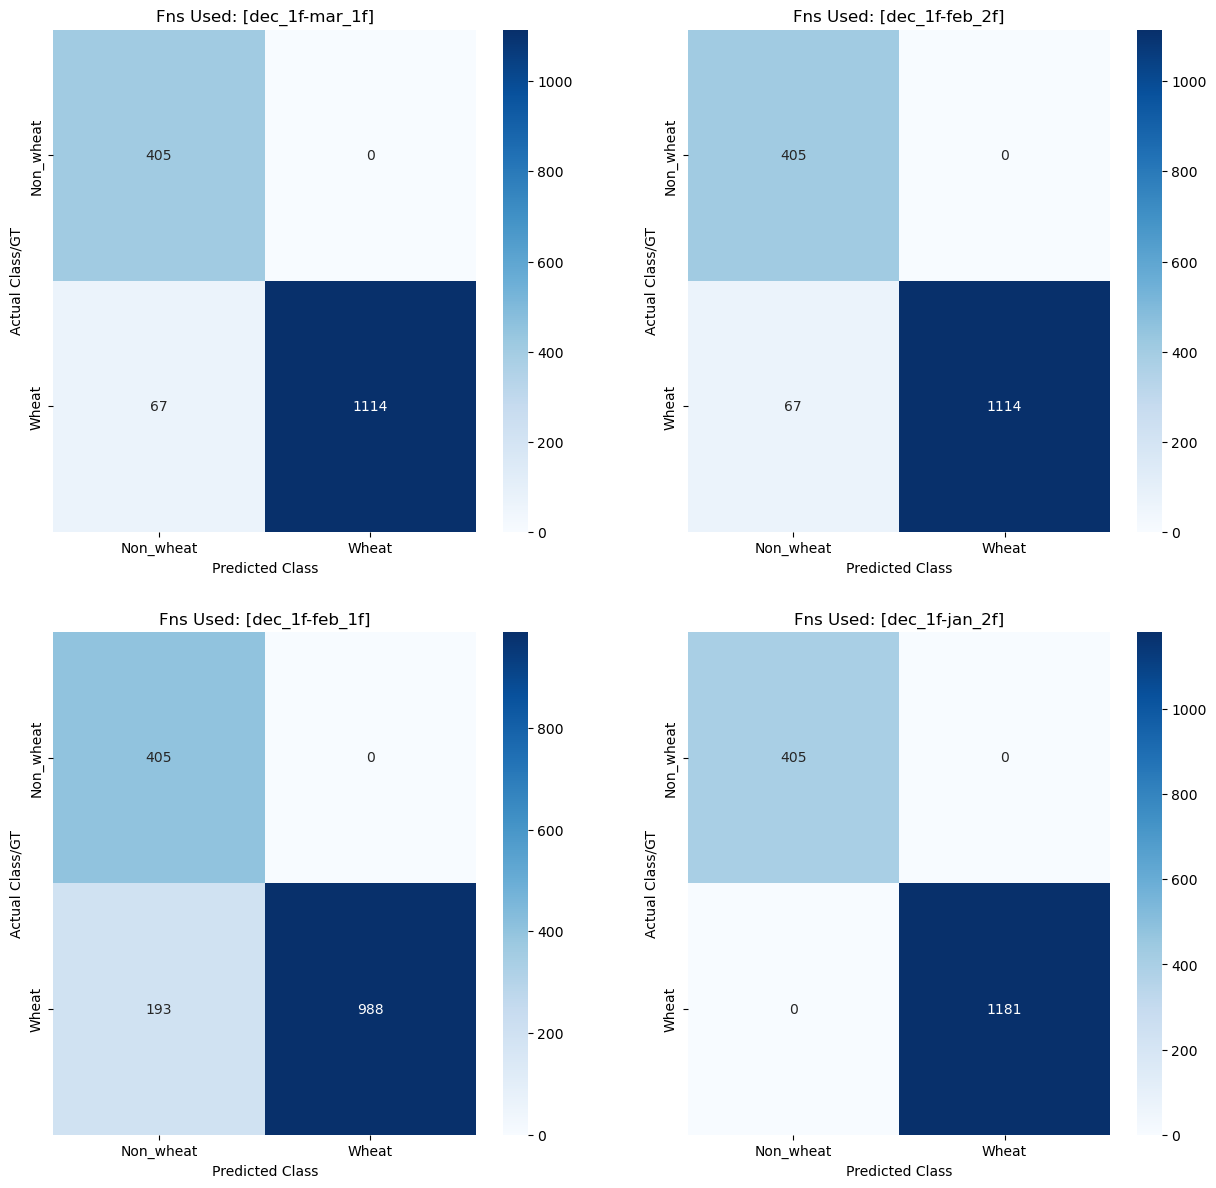

In [39]:
plt.figure(figsize=(15,30))

for i in range(len(confusion_matrices)):
    plt.subplot(4,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'Fns Used: [{fns_used[i]}]')
plt.show()

# Sowing Period Classification

In [329]:
threshold = 5

def sowing_period(row):
    sowing_periods = row.index[:5]
    sowing_periods_NDVI = row[:5]
    minima = np.argmin(sowing_periods_NDVI)
    ndvi_values = row.loc[:'apr_1f']
    i = minima
    while i < len(sowing_periods):
#         print(ndvi_values[idx])
        if ndvi_values[i] in set(np.arange(110, 141)):
            if (ndvi_values[i+1] - ndvi_values[i]) > threshold:
                if ndvi_values[i+1] < ndvi_values[i+4]:
                    return 'Wheat_'+sowing_periods[i]
        i += 1
    return 'Unknown'

In [330]:
wheat['pred'] = wheat.apply(sowing_period, axis=1)

In [331]:
pd.crosstab(wheat['label'], wheat['pred'])

pred,Unknown,Wheat_dec_1f,Wheat_dec_2f,Wheat_nov_1f,Wheat_nov_2f,Wheat_oct_2f
label,,,,,,
Wheat_dec_1f,13,5286,0,207,35,11
Wheat_dec_2f,4,0,197,8,36,0
Wheat_nov_1f,2,0,0,3280,322,32
Wheat_nov_2f,8,1,0,128,7010,25
Wheat_oct_2f,0,0,0,0,0,94


In [332]:
wheat[(wheat.label == 'Wheat_dec_1f') & (wheat.pred == 'Wheat_nov_1f')].iloc[:,:-3].sample(5, random_state=42)

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f
14293,130,122,131,126,189,190,189,189,187,176,129
11389,133,117,123,127,154,172,174,183,184,173,123
12840,122,126,134,135,164,182,192,189,191,188,160
13307,138,125,133,133,189,188,186,188,185,174,127
14323,130,125,131,126,162,180,181,186,183,179,153


<Axes: >

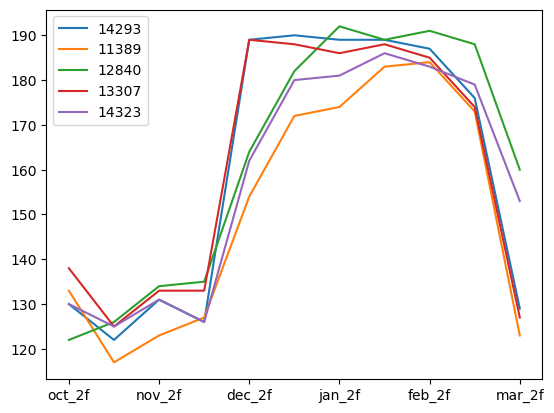

In [333]:
wheat[(wheat.label == 'Wheat_dec_1f') & (wheat.pred == 'Wheat_nov_1f')].iloc[:,:-3].sample(5, random_state=42).T.plot()

oct_2f             123
nov_1f             120
nov_2f             127
dec_1f             123
dec_2f             155
jan_1f             183
jan_2f             187
feb_1f             189
feb_2f             185
mar_1f             182
mar_2f             133
apr_1f             117
label     Wheat_dec_1f
pred      Wheat_nov_1f
Name: 14217, dtype: object

(None, <Axes: >)

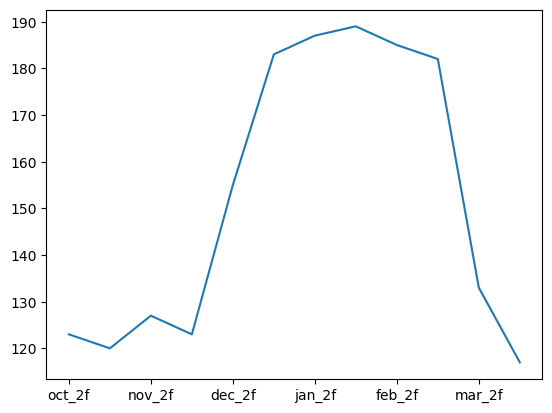

In [334]:
display(wheat.loc[14217]),wheat.loc[14217,:'apr_1f'].plot()

In [335]:
wheat.groupby('label').min()

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,pred
label,,,,,,,,,,,,,
Wheat_dec_1f,83,1,112,110,0,160,170,176,180,165,0,0,Unknown
Wheat_dec_2f,119,110,115,115,118,160,170,175,180,170,126,1,Unknown
Wheat_nov_1f,112,107,114,145,156,165,151,141,119,89,0,0,Unknown
Wheat_nov_2f,96,107,109,116,150,160,170,175,122,90,0,0,Unknown
Wheat_oct_2f,116,125,150,165,171,172,167,144,120,115,1,105,Wheat_oct_2f


In [336]:
wheat.max(axis=1).unique()

array([191, 189, 193, 190, 196, 195, 188, 192, 199, 185, 184, 186, 197,
       187, 194, 183, 178, 181, 179, 182, 176, 200, 180, 198, 173, 174,
       177, 172, 171])

In [250]:
wheat.to_csv('wheat.csv')

In [257]:
diff_wheat = wheat[wheat.pred != 'Unknown'].loc[:,:'apr_1f'].diff(axis=1)

diff_wheat['pred'] = wheat[wheat.pred != 'Unknown']['pred']
diff_wheat['label'] = wheat[wheat.pred != 'Unknown']['label']

In [258]:
diff_wheat

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,pred,label
0,NaN,37,31,1,5,0,-6,-8,-46,-11,-6,6,Wheat_oct_2f,Wheat_oct_2f
1,NaN,35,19,10,7,-8,-8,-16,-33,-6,-5,-1,Wheat_oct_2f,Wheat_oct_2f
2,NaN,40,27,4,3,-2,-13,-34,-22,-5,-4,1,Wheat_oct_2f,Wheat_oct_2f
3,NaN,39,28,4,3,-2,-13,-32,-25,-2,-2,-1,Wheat_oct_2f,Wheat_oct_2f
4,NaN,32,33,6,-1,-1,-2,-16,-38,-11,-8,-1,Wheat_oct_2f,Wheat_oct_2f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16704,NaN,-7,4,-14,5,27,7,12,1,-3,-40,-16,Wheat_dec_2f,Wheat_dec_2f
16705,NaN,-13,-1,-13,5,28,7,12,1,-4,-38,-16,Wheat_dec_2f,Wheat_dec_2f
16706,NaN,-29,-4,-6,5,38,5,10,-1,1,-15,-33,Wheat_dec_2f,Wheat_dec_2f
16707,NaN,-15,-14,-26,5,45,5,17,3,-4,-35,-39,Wheat_dec_2f,Wheat_dec_2f


In [260]:
diff_wheat['pred']=diff_wheat.pred.apply(lambda val:val[6:])

In [273]:
diff_wheat.apply(func, axis=1).values

array([37, 35, 40, ..., 38, 45, 45], dtype=int64)

In [278]:
df = pd.DataFrame({'pred':diff_wheat.pred.values, 'diff':diff_wheat.apply(func, axis=1).values})

In [292]:
diff_wheat = wheat[wheat.pred == 'Unknown'].loc[:,:'apr_1f'].diff(axis=1)

diff_wheat['pred'] = wheat[wheat.pred == 'Unknown']['pred']

diff_wheat['label'] = wheat[wheat.pred == 'Unknown']['label']
diff_wheat['label']=diff_wheat.label.apply(lambda val:val[6:])

In [338]:
def func(row):
#     print(list(row.index).index(row['pred']))
    idx = list(row.index).index(row['label'])
    return row[idx+1]

In [345]:
wo_unk = wheat[(wheat.pred != 'Unknown')]
wo_unk['label']=wo_unk.label.apply(lambda val:val[6:])
wo_unk[]wo_unk.apply(func, axis=1) < 130
wo_unk.apply(func, axis=1)[wo_unk.apply(func, axis=1) < 130]

114

In [296]:
df = pd.DataFrame({'label':diff_wheat.label.values, 'diff':diff_wheat.apply(func, axis=1).values})

In [307]:
wheat[(wheat.pred == 'Unknown') & (wheat.label == 'Wheat_dec_1f')]

,oct_2f,nov_1f,nov_2f,dec_1f,dec_2f,jan_1f,jan_2f,feb_1f,feb_2f,mar_1f,mar_2f,apr_1f,label,pred
10963,144,132,126,131,191,188,192,190,186,169,127,115,Wheat_dec_1f,Unknown
10988,159,152,125,130,184,186,176,183,182,166,156,146,Wheat_dec_1f,Unknown
11048,156,123,124,129,200,180,186,187,188,180,122,114,Wheat_dec_1f,Unknown
11365,155,142,127,131,186,183,183,186,184,175,128,117,Wheat_dec_1f,Unknown
12391,136,121,122,124,200,162,178,183,186,184,154,123,Wheat_dec_1f,Unknown
12397,159,124,126,128,200,182,186,187,188,182,125,114,Wheat_dec_1f,Unknown
12559,136,122,124,126,194,192,192,192,191,183,135,118,Wheat_dec_1f,Unknown
12736,159,139,139,140,182,181,184,179,183,167,137,129,Wheat_dec_1f,Unknown
13476,150,126,131,130,185,182,185,184,182,167,123,114,Wheat_dec_1f,Unknown
14525,141,127,133,125,190,189,190,190,189,184,142,119,Wheat_dec_1f,Unknown


In [297]:
df.groupby('label')['diff'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
dec_1f,13.0,18.461538,82.915233,-135.0,42.00,55.0,68.0,76.0
dec_2f,4.0,69.000000,5.354126,66.0,66.00,66.5,69.5,77.0
nov_1f,2.0,5.000000,0.000000,5.0,5.00,5.0,5.0,5.0
nov_2f,8.0,67.250000,8.481071,49.0,65.75,67.5,72.5,77.0


In [280]:
df.groupby('pred')['diff'].describe()

,count,mean,std,min,25%,50%,75%,max
pred,,,,,,,,
dec_1f,5287.0,28.868356,11.711247,6.0,19.00,29.0,37.00,67.0
dec_2f,197.0,35.791878,6.768952,21.0,31.00,35.0,41.00,51.0
nov_1f,3623.0,12.033122,6.298791,6.0,8.00,10.0,14.00,39.0
nov_2f,7403.0,19.487910,12.105218,6.0,10.00,15.0,28.00,68.0
oct_2f,162.0,16.135802,11.577718,6.0,7.25,11.0,21.75,58.0


In [262]:
def func(row):
#     print(list(row.index).index(row['pred']))
    idx = list(row.index).index(row['pred'])
    return row[idx+1]

In [226]:
wheat.pred.unique()

array(['oct_2f', 'nov_1f', 'nov_2f', 'n', 'dec_1f', 'dec_2f'],
      dtype=object)

oct_2f             159
nov_1f             139
nov_2f             139
dec_1f             140
dec_2f             182
jan_1f             181
jan_2f             184
feb_1f             179
feb_2f             183
mar_1f             167
mar_2f             137
apr_1f             129
label     Wheat_dec_1f
pred           Unknown
Name: 12736, dtype: object

(None, <Axes: >)

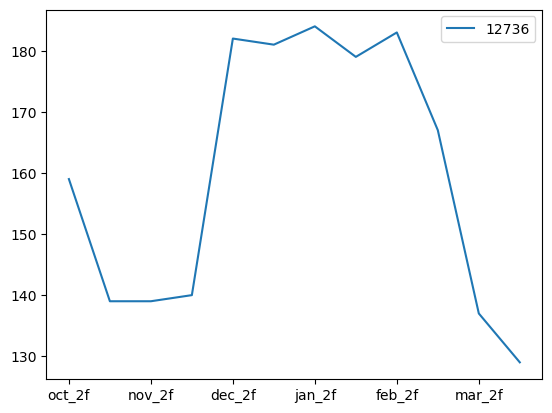

In [167]:
display(wheat.loc[12736]), wheat[wheat.pred == 'Unknown'].loc[:,:'apr_1f'].sample(1, random_state=2).T.plot()

In [36]:
!pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install

[I 16:29:01 InstallContribNbextensionsApp] jupyter contrib nbextension install 
[I 16:29:01 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 16:29:01 InstallContribNbextensionsApp] Installing C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore -> addbefore
[I 16:29:01 InstallContribNbextensionsApp] Making directory: C:\ProgramData\jupyter\nbextensions\addbefore\
[I 16:29:01 InstallContribNbextensionsApp] Copying: C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore\addbefore.yaml -> C:\ProgramData\jupyter\nbextensions\addbefore\addbefore.yaml
[I 16:29:01 InstallContribNbextensionsApp] Copying: C:\Users\user\miniconda3\envs\kdss_base\lib\site-packages\jupyter_contrib_nbextensions\nbextensions\addbefore\icon.png -> C:\ProgramData\jupyter\nbextensions\addbefore\icon.png
[I 16:29:01 InstallContribNbextensions